# GoogleHydrology Finetuning Tutorial Notebook: Exploring Base Models and Targeted Fine-Tuning

Welcome to this interactive tutorial designed to help you understand the concepts of base hydrological models and the powerful technique of fine-tuning, using the `googlehydrology` framework. This notebook is structured as a student exercise, aiming to provide a hands-on experience in evaluating and improving predictive models.

## What You Will Learn:

By working through this notebook, you will gain insights into:

1.  **Understanding Base Models:** How a general-purpose hydrological model, trained on a diverse set of basins, serves as a foundation for further specialization.
2.  **The Concept of Fine-Tuning:** The process of adapting a pre-trained model to improve its performance on a specific target or region that might be 'out-of-distribution' compared to the base model's training data.
3.  **Running `googlehydrology` Models:** Practical experience in generating and understanding the command-line arguments for training (`train`), fine-tuning (`finetune`), and performing inference (`infer`) with the `googlehydrology` framework. You will learn how to prepare config files and execute these operations, typically in a terminal environment.
4.  **Model Performance Analysis:** How to quantitatively evaluate model performance using various metrics (e.g., KGE, NSE) and qualitatively assess predictions through hydrograph comparisons.
5.  **Impact of Static Attributes:** The critical role of static basin attributes (like basin area) in model performance and how targeted fine-tuning of specific model layers (e.g., `static_attributes_fc`) can address discrepancies when a target basin's characteristics differ significantly from the base model's training distribution.

For more detailed insights into fine-tuning for river modeling, refer to the paper: Ryd, Emil, and Grey Nearing. "Fine Flood Forecasts: Incorporating local data into global models through fine-tuning." arXiv preprint arXiv:2504.12559 (2025). [https://arxiv.org/abs/2504.12559](https://arxiv.org/abs/2504.12559)

## Notebook Workflow:

This notebook follows a structured approach to guide you through the comparison of a **base model** and a corresponding **fine-tuned model**. The key steps include:

1.  **Configuration:** Setting up local paths for model runs, shapefiles, and attribute data.
2.  **Base Model Exploration:** Selecting a base model, visualizing its training and testing basins, generating its run commands, calculating performance metrics, and visualizing score distributions.
3.  **Fine-Tuning Process:** Choosing a specific target basin for fine-tuning, understanding how to configure the fine-tuning run, and generating the necessary fine-tuning and inference commands.
4.  **Fine-Tuned Model Analysis:** Selecting the fine-tuned model and loading its performance metrics.
5.  **Comparative Analysis:** Directly comparing the base and fine-tuned models' performance on the target basin using both metric-versus-lead-time plots and detailed hydrograph comparisons.
6.  **Basin Context:** Examining the basin area distribution of the training data relative to the fine-tuning target basin to understand the rationale behind targeted fine-tuning strategies, particularly concerning the `static_attributes_fc` layer.

By the end of this tutorial, you should have a solid understanding of how to leverage pre-trained hydrological models and adapt them for specific regional challenges, ultimately contributing to more accurate flood forecasting.

## Imports

In [1]:
# --- Install Dependencies ---
# These lines ensure that all required third-party libraries are installed.
# These are not needed if you use the supplied `googlehydrology` conda
# environment in `~/flood-forecasting/environments/conda.yml`

# Data visualization and interactive widgets
pip install matplotlib seaborn ipywidgets

# Scientific computing and data structures
pip install numpy pandas xarray netCDF4

# Google Cloud Storage (for MultiMet data access)
pip install google-cloud-storage gcsfs

In [2]:
# Standard Library Imports
import os
from typing import Optional, Set # Used for type hints, improving code readability and maintainability.

# Third-Party Library Imports
import ipywidgets as widgets # Used to create interactive elements like dropdowns, sliders, etc.
from ipywidgets import interactive, VBox # 'interactive' is for easily creating UIs for functions, and 'VBox' is for vertically organizing widgets in the notebook.
import matplotlib.pyplot as plt # Used for generating static, animated, and interactive visualizations (plots and charts).
import pandas as pd # Used for data manipulation and analysis, especially with DataFrames.

# Local tutorial Module Imports
import backend # This is a local module containing custom functions specific to the tutorial for tasks like data loading, metric calculation, and plotting.

In [3]:
%matplotlib inline

## User-Defined Local Paths


In [4]:
# Define the path to the shapefile containing basin geometries.
# This shapefile is crucial for plotting maps of basin locations and visualizing model skill geographically.
# Users may need to update this path if their data is stored elsewhere.
SHAPEFILE_PATH = '~/flood-forecasting/tutorial/Caravan-nc/shapefiles/camels/camels_basin_shapes.shx'

# Path to the attributes file that contains additional basin information, such as basin area.
# This file is used for more detailed analysis and visualization, like the distribution of basin areas.
ATTRIBUTES_FILE_PATH = '~/flood-forecasting/tutorial/Caravan-nc/attributes/camels/attributes_other_camels.csv'

# Path to a base directory containing one or more model run directories.
# This directory should house all your trained models (base and fine-tuned).
# The interactive selection widgets in subsequent cells will scan this directory to allow you to choose which model run to evaluate.
MODEL_RUN_DIR = '/home/gsnearing/flood-forecasting/tutorial/model-runs/'

# A boolean flag to control whether performance statistics (metrics) are recalculated or loaded from pre-existing files.
# Set this to 'True' for the initial run or if model outputs have changed and you need fresh calculations.
# Set to 'False' if metrics have already been computed and saved, to save time during subsequent runs.
# This is particularly useful for live demos or quick comparisons where recalculation is not necessary.
CALCULATE_STATISTICS = False

## Interactive Functions

In [5]:
def select_model(model_selection):
    """
    Sets the global variables for the selected base model run directory and name.

    This function is designed to be used with an `ipywidgets.Dropdown` to allow
    interactive selection of a model. It updates two global variables:
    - `model_run_dir`: The absolute path to the directory of the selected model run.
    - `model_name`: A user-friendly display name for the selected model.

    Args:
        model_selection (str): The key (display name) of the selected model run
                                from the available options in the dropdown.
    """
    global model_run_dir, model_name

    # Get the absolute path for the selected run directory from the pre-populated dictionary
    model_run_dir = available_run_dirs.get(model_selection)
    # Create a display name for the selected model, including its selection identifier
    model_name = f'Model ({model_selection})'

    print("\nConfiguration set:")
    print(f"  Model: {model_name} ({model_run_dir})")

## Base Model

### Run Command

In [6]:
# --- Base Model: Generate Run Commands ---

# This cell generates the commands needed to train and run inference for the base model.
# These commands are typically executed outside of this notebook in a terminal or a separate process
# that has access to the `flood-forecasting/googlehydrology` project and its
# required Python environment (e.g., a Conda environment).

# Get the experiment name. We are assuming '5-basin-example' as the base experiment
# because the base_config may not be loaded yet at this stage.
base_experiment_name = '5-basin-example'
base_config_file = f"config-files/{base_experiment_name}.yml"

# Construct the base model training command.
# This command initiates the training process for the base model, using its specific configuration file.
base_train_command = f"run train --config-file={base_config_file}"

# Construct the base model inference command.
# After a base model has been trained, this command is used to run predictions
# (inference) using the trained model. It specifies the `--run-dir`
# which points to the output directory of the base model training run.
# NOTE: At this stage, the actual run directory might not exist yet if you are training a new model.
# You will need to replace '<YOUR_BASE_MODEL_RUN_DIR>' with the actual directory name created by STEP 1.
base_infer_command = f"run infer --run-dir=model-runs/<YOUR_BASE_MODEL_RUN_DIR>"

# Print the run instructions to the screen
print("--------------------------------------------------------------------------------------------------")
print("                          BASE MODEL TRAINING AND INFERENCE INSTRUCTIONS                          ")
print("--------------------------------------------------------------------------------------------------")
print("These commands need to be executed in your terminal or a separate process.")
print("Ensure you are in an environment with the necessary Python libraries (e.g., the `googlehydrology` Conda environment).")
print("")
print("IMPORTANT: Before running these commands, please examine the configuration file:")
print(f"  Config File Location: {base_config_file}")
print("  This file defines crucial parameters for your model run, including data paths, model architecture, and training settings.")
print("  Understanding its contents will help you customize and debug your experiments.")
print("")
print("STEP 1: Run the base model training command FIRST (if you need to train a new base model):")
print(f"    {base_train_command}")
print("")
print("STEP 2: After the base model training is complete, run the inference command:")
print("    (IMPORTANT: Replace '<YOUR_BASE_MODEL_RUN_DIR>' with the actual run directory created by STEP 1, e.g., 'model-runs/5-basin-example_YYYYMMDD_HHMMSS')")
print(f"    {base_infer_command}")
print("")
print("--------------------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------------------
                          BASE MODEL TRAINING AND INFERENCE INSTRUCTIONS                          
--------------------------------------------------------------------------------------------------
These commands need to be executed in your terminal or a separate process.
Ensure you are in an environment with the necessary Python libraries (e.g., the `googlehydrology` Conda environment).

IMPORTANT: Before running these commands, please examine the configuration file:
  Config File Location: config-files/5-basin-example.yml
  This file defines crucial parameters for your model run, including data paths, model architecture, and training settings.
  Understanding its contents will help you customize and debug your experiments.

STEP 1: Run the base model training command FIRST (if you need to train a new base model):
    run train --config-file=config-files/5-basin-example.yml

STEP 2: Afte

### Choose Base Model

This section allows you to select a **base model** from your local `MODEL_RUN_DIR`. The notebook automatically scans this directory (including subdirectories) to find all available model run folders. Each folder represents a unique experiment or training run.

An interactive dropdown widget is then populated with the names of these detected runs. Selecting an option from this dropdown will set the `model_run_dir` and `model_name` global variables, which are used throughout the rest of the notebook for loading data and calculating metrics for the chosen base model.


In [7]:
# Find available run directories using the path set in the cell above
available_run_dirs = backend.find_model_run_dirs(MODEL_RUN_DIR)

# Create a dropdown widget for selecting the base model
run_dir_options = sorted(available_run_dirs.keys())
base_dropdown = widgets.Dropdown(
    options=run_dir_options,
    description='Select Base Model:',
    disabled=False,
    style = {'description_width': 'initial'}
)

# Create an interactive widget linking the dropdown to the selection function
interactive_selection = interactive(
    select_model,
    model_selection=base_dropdown,
)

# Display the interactive widget
display(interactive_selection)

interactive(children=(Dropdown(description='Select Base Model:', options=('5-basin-example', '530-camels'), st…

### Visualize Train and Test Basins

Loaded 5 training basin IDs.
Loaded 8 test basin IDs.


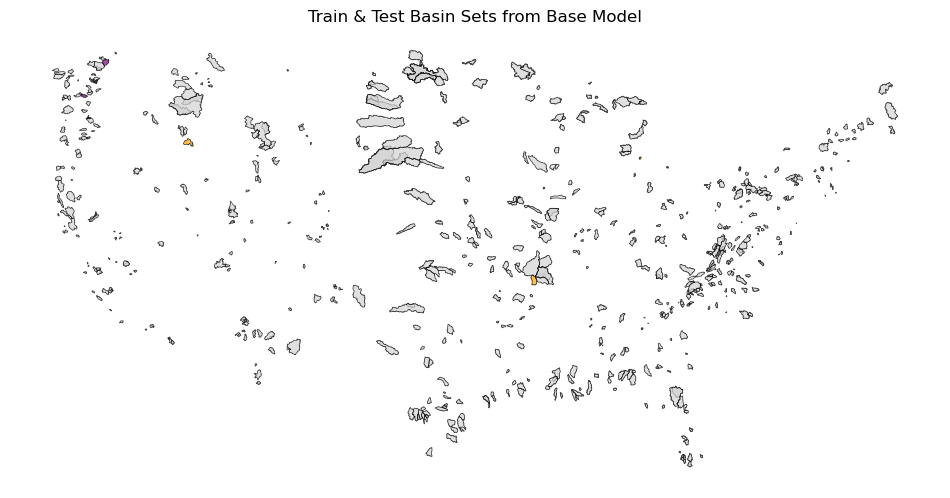

In [8]:
# Load train and test basin lists
# `backend.load_model_config_and_basins` reads the configuration file of the selected base model
# (from the `model_run_dir`) to extract which basins were used for training and testing.
# It returns the configuration dictionary, and sets of training and testing basin IDs.
base_config, train_basin_ids, test_basin_ids = backend.load_model_config_and_basins(model_run_dir)

# Plot train and test basins
# `backend.plot_train_test_shapefile` visualizes the geographical locations of the
# training and testing basins on a map. It uses the `SHAPEFILE_PATH` to draw the basin
# boundaries, highlights `train_basin_ids` and `test_basin_ids` with different colors,
# and uses `model_name` for the plot title.
backend.plot_train_test_shapefile(
    shapefile_path=SHAPEFILE_PATH,
    train_basin_ids=train_basin_ids,
    test_basin_ids=test_basin_ids,
    model_name=model_name
)

### Calculate Metrics

In [9]:
# Load simulation data and calculate/load metrics for the base model.
# `backend.load_data_and_metrics` handles reading the raw model outputs
# and, if specified, computes performance metrics across different lead times.
# It requires the `model_run_dir` to locate the data and `test_basin_ids` to filter for relevant basins.
base_model_data, base_model_metrics = backend.load_data_and_metrics(
    model_run_dir=model_run_dir,
    test_basin_ids=test_basin_ids,
    # The 'calculate_statistics' parameter controls whether metrics are re-calculated
    # or loaded from a pre-saved file. Setting it to `True` (as done here temporarily)
    # forces recalculation, which is useful after a new model run or if previous
    # calculations are outdated. If set to `False` (referencing the global
    # CALCULATE_STATISTICS), it will load existing metrics if available, saving time.
    calculate_statistics=CALCULATE_STATISTICS,
    model_name=model_name
)

# `base_model_data` will contain the raw simulation outputs (e.g., streamflow_sim, streamflow_obs)
# typically as an xarray Dataset, allowing for detailed hydrograph analysis.
# `base_model_metrics` will be a pandas DataFrame containing calculated performance scores
# (e.g., KGE, NSE) for each basin and lead time, used for quantitative comparisons.

if base_model_metrics is not None:
    display(base_model_metrics.head())
else:
    print("Base model metrics could not be loaded or calculated.")

Loading Model (5-basin-example) results from: /home/gsnearing/flood-forecasting/tutorial/model-runs/5-basin-example ... simulations loaded successfully.


NSE        MSE      RMSE       KGE  \
basin_id        lead_time                                              
camels_04115265 0         -248.517838  54.593807  7.388762 -9.194997   
                1         -248.416626  54.645683  7.392272 -9.178265   
                2         -248.899323  54.822891  7.404248 -9.203243   
                3         -247.581512  54.604065  7.389456 -9.157355   
                4         -243.908813  53.860836  7.338994 -9.071673   

                           Alpha-NSE  Pearson-r  Beta-KGE   Beta-NSE  \
basin_id        lead_time                                              
camels_04115265 0           7.021340   0.056866  9.172632  14.142744   
                1           6.970496   0.052562  9.188566  14.161977   
                2           7.009151   0.052788  9.191401  14.160195   
                3           6.938488   0.039793  9.184389  14.141823   
                4           6.863211   0.040268  9.132667  14.048411   

                                 FHV        FMS        FLV  Peak-Timing  \
basin_id        lead_time                                                 
camels_04115265 0          516.73300  33.150290  75.568634          0.0   
                1          514.82904  30.977818  71.752190          0.2   
                2          518.70120  30.661652  72.079370          0.4   
                3          504.34980  32.492900  72.915940          0.8   
                4          500.90560  29.933878  74.938920          1.0   

                           Missed-Peaks  Peak-MAPE  
basin_id        lead_time                           
camels_04115265 0              0.928571  172.30898  
                1              0.928571  169.48871  
                2              1.000000  171.80103  
                3              1.000000  164.08043  
                4              0.785714  147.74135

### Visualize Score Distributions

In [10]:
# Get the list of available metrics from the columns of the base model metrics DataFrame.
# This ensures the dropdown only presents metrics that have actually been calculated and are present.
available_metrics = list(base_model_metrics.columns)

# Create a dropdown widget for selecting a metric to plot at lead time 0.
# The default value is 'KGE' if available, otherwise it defaults to the first metric in the list.
metric_widget = widgets.Dropdown(
    options=available_metrics,
    value='KGE' if 'KGE' in available_metrics else available_metrics[0],
    description='Select Metric for Lead Time 0 Plot:',
    disabled=False,
    style = {'description_width': 'initial'}
)

# Create an interactive widget that links the 'metric_widget' dropdown to the 'plot_lead_time_zero_scores' function.
# `widgets.fixed` is used to pass static arguments (like dataframes and basin IDs) that do not change
# when the dropdown value is altered, making the plot update dynamically only based on the selected metric.
interactive_plot = interactive(
    backend.plot_lead_time_zero_scores,
    metrics_df=widgets.fixed(base_model_metrics),
    train_basin_ids=widgets.fixed(train_basin_ids),
    test_basin_ids=widgets.fixed(test_basin_ids),
    metric_name=metric_widget,
    model_name=widgets.fixed(model_name if 'model_name' in globals() else 'Base Model')
)

# Display the interactive widget, which includes the dropdown and the output plot.
display(interactive_plot)

interactive(children=(Dropdown(description='Select Metric for Lead Time 0 Plot:', index=3, options=('NSE', 'MS…

## Fine Tuning

### Choose Basin

/home/gsnearing/miniconda3/envs/googlehydrology/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


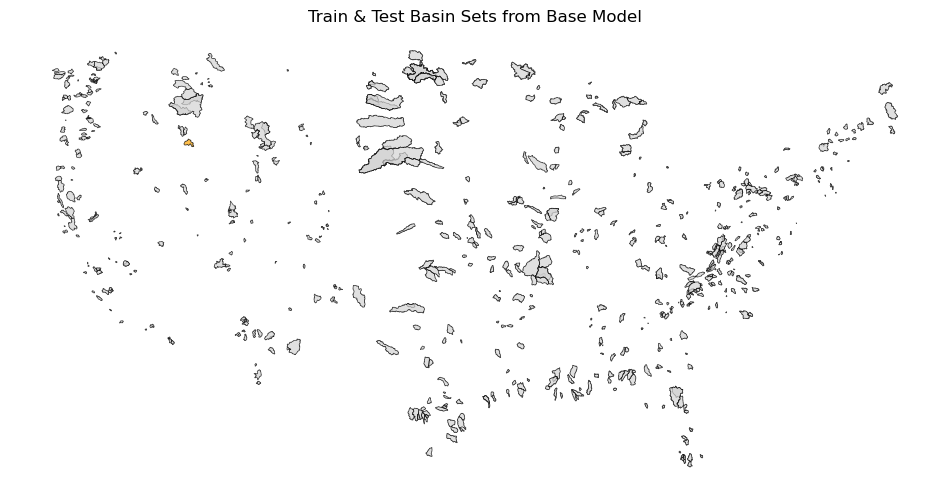

In [11]:
# --- Fine-Tuning: Choose Basin for Fine-Tuning ---

# This cell is dedicated to interactively selecting and visualizing the specific
# basin that will be targeted for fine-tuning. The goal is to improve the
# model's performance specifically for this chosen basin.

# Manually define the basin ID to use for fine-tuning.
# This is a critical step where you decide which basin the fine-tuning process
# will focus on. The selected basin's data will be used to further train
# the base model.
# Example for CAMELS dataset: Basin with a low KGE score.
# You can change this value to any valid basin ID from your dataset.
FINE_TUNING_BASIN = '13235000' # Example for small model run in live demo.

# Plot the selected fine-tuning basin using the shapefile function.
# This visualization helps confirm that the correct basin has been selected
# and allows for a geographical context of the fine-tuning target.
# `backend.plot_train_test_shapefile` is a utility function that draws basin boundaries
# on a map, highlighting specific basins.
backend.plot_train_test_shapefile(
    shapefile_path=SHAPEFILE_PATH,         # Path to the shapefile containing basin geometries.
    train_basin_ids=set(),                # An empty set because we are not highlighting training basins here.
    test_basin_ids={FINE_TUNING_BASIN},   # A set containing only the chosen fine-tuning basin ID to highlight it.
    model_name=f"Fine-Tuning Basin: {FINE_TUNING_BASIN}" # Updates the plot title to indicate the fine-tuning basin.
)

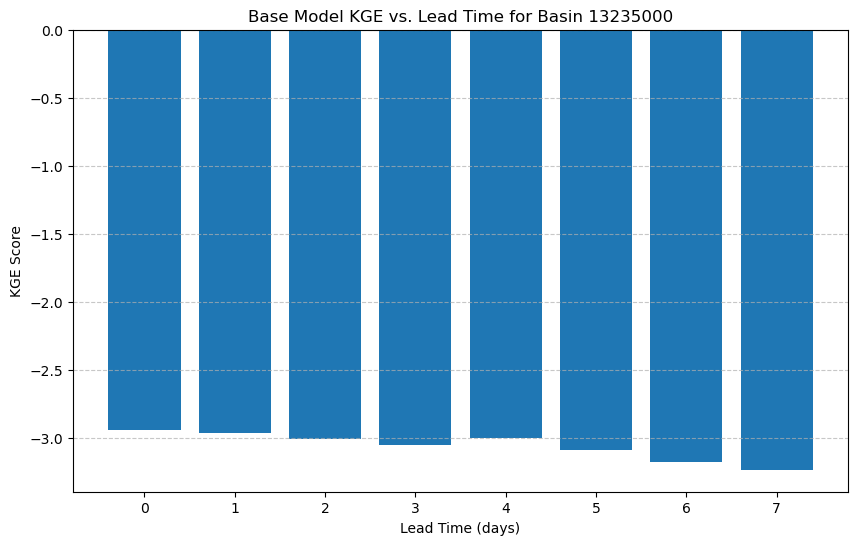

In [12]:
finetune_basin_kge_scores = base_model_metrics.loc[f'camels_{FINE_TUNING_BASIN}', 'KGE']

# Create a simple bar chart
plt.figure(figsize=(10, 6))
plt.bar(finetune_basin_kge_scores.index, finetune_basin_kge_scores.values)

plt.title(f"Base Model KGE vs. Lead Time for Basin {FINE_TUNING_BASIN}")
plt.xlabel("Lead Time (days)")
plt.ylabel("KGE Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(finetune_basin_kge_scores.index)
plt.show()

### Run Command

In [13]:
# --- Fine-Tuning: Generate Run Command ---

# This cell generates the commands needed to run the fine-tuning experiment
# and subsequent inference for the selected basin.

# Assumes FINE_TUNING_BASIN is available globally from the previous cell (yhaN9WfT9djN).

# Construct the fine-tuning training command.
# This command initiates the fine-tuning process. It calls the `run.py` script
# with the `finetune` action and specifies a configuration file (`.yml`).
# The configuration file contains parameters specific to the fine-tuning run,
# including the base model to start from and the data for the target basin.
finetune_train_command = f"run finetune --config-file=config-files/finetune-camels-{FINE_TUNING_BASIN}.yml"

# Construct the fine-tuning inference command.
# After a model has been fine-tuned, this command is used to run predictions
# (inference) using the newly fine-tuned model. It specifies the `--run-dir`
# which points to the output directory of the fine-tuned model training run.
finetune_infer_command = f"run infer --run-dir={model_run_dir}/finetune-camels-{FINE_TUNING_BASIN}..."


# Print the run instructions to the screen
print("--------------------------------------------------------------------------------------------------")
print("                       FINE-TUNING AND INFERENCE RUN INSTRUCTIONS                           ")
print("--------------------------------------------------------------------------------------------------")
print("These commands need to be executed in your terminal or a separate process.")
print("Ensure you are in an environment with the necessary Python libraries (e.g., the `googlehydrology` Conda environment).")
print("")
print("IMPORTANT: Before running these commands, please examine the fine-tuning configuration file:")
print(f"  Config File Location: config-files/finetune-camels-{FINE_TUNING_BASIN}.yml")
print("  This file defines crucial parameters for your fine-tuning run, including the base model to use, target basin, and fine-tuning specific settings.")
print("  Understanding its contents will help you customize and debug your experiments.")
print("  Specifically, you will need to update two parameters within this config file:")
print("    - `base_run_dir`: This should point to the directory of the pre-trained base model you selected, e.g., `model-runs/5-basin-example_0811_135051`.")
print("    - `run_dir`: This parameter defines where the fine-tuned model's outputs will be stored. It should also be set to the same base model run directory, e.g., `model-runs/5-basin-example_0811_135051`.")
print("")
print("STEP 1: Run the fine-tuning training command FIRST:")
print(f"    {finetune_train_command}")
print("")
print("STEP 2: After the fine-tuning training is complete, run the inference command:")
print(f"    {finetune_infer_command}")
print("")
print("--------------------------------------------------------------------------------------------------")


--------------------------------------------------------------------------------------------------
                       FINE-TUNING AND INFERENCE RUN INSTRUCTIONS                           
--------------------------------------------------------------------------------------------------
These commands need to be executed in your terminal or a separate process.
Ensure you are in an environment with the necessary Python libraries (e.g., the `googlehydrology` Conda environment).

IMPORTANT: Before running these commands, please examine the fine-tuning configuration file:
  Config File Location: config-files/finetune-camels-13235000.yml
  This file defines crucial parameters for your fine-tuning run, including the base model to use, target basin, and fine-tuning specific settings.
  Understanding its contents will help you customize and debug your experiments.
  Specifically, you will need to update two parameters within this config file:
    - `base_run_dir`: This should point to the d

### Select Fine Tuning Model Run

In [14]:
# --- Fine-Tuning: Select Fine-Tuning Model Run ---

# Construct the path to the fine-tuned model directory.
# We assume the fine-tuning output is located inside the base model directory,
# named 'finetune-<BASIN_ID>'.
finetune_run_dir = os.path.join(model_run_dir, f'finetune-camels-{FINE_TUNING_BASIN}')

# Update the global variables to point to the fine-tuned model.
# This ensures that the next cell (metrics calculation) loads data from this new directory.
model_name = f'Fine-Tuned Model ({FINE_TUNING_BASIN})'

print(f"Selected Fine-Tuned Model: {model_name}")
print(f"Run Directory: {finetune_run_dir}")

Selected Fine-Tuned Model: Fine-Tuned Model (13235000)
Run Directory: /home/gsnearing/flood-forecasting/tutorial/model-runs/5-basin-example/finetune-camels-13235000


### Calculate Metrics

In [15]:
# --- Fine-Tuning: Calculate Metrics ---

# This cell is responsible for loading the configuration and test basin IDs for the
# selected fine-tuned model, and then either calculating or loading its performance metrics.
# It mirrors the process used for the base model but focuses on the fine-tuned experiment.

# Load configuration and basin IDs for the fine-tuned model.
# `backend.load_model_config_and_basins` reads the configuration file associated with
# the `finetune_run_dir` (which was set in the cell above).
# It extracts the experiment's configuration details, as well as the training and testing
# basin IDs used for this specific fine-tuned run.
finetune_config, finetune_train_basin_ids, finetune_test_basin_ids = backend.load_model_config_and_basins(finetune_run_dir)

# Load simulation data and calculate/load metrics for the fine-tuned model.
# `backend.load_data_and_metrics` performs the heavy lifting of reading raw model outputs
# and, based on the `CALCULATE_STATISTICS` flag, computes or loads performance metrics.
# - `model_run_dir`: The directory of the fine-tuned model run selected in the previous step.
# - `finetune_test_basin_ids`: The set of basin IDs that were used for testing this fine-tuned model.
# - `CALCULATE_STATISTICS`: A global boolean flag. If `True`, metrics are recalculated;
#   if `False`, pre-saved metrics are loaded to save computation time.
# - `model_name`: A descriptive name for the fine-tuned model, used for display purposes.
finetune_data, finetune_metrics = backend.load_data_and_metrics(
    model_run_dir=finetune_run_dir,
    test_basin_ids=finetune_test_basin_ids,
    calculate_statistics=CALCULATE_STATISTICS,
    model_name=model_name
)

# Display the head of the calculated/loaded fine-tuned model metrics DataFrame.
# This provides a quick overview of the metrics, including basin IDs, lead times, and scores.
display(finetune_metrics.head())

Loaded 1 training basin IDs.
Loaded 8 test basin IDs.
Loading Fine-Tuned Model (13235000) results from: /home/gsnearing/flood-forecasting/tutorial/model-runs/5-basin-example/finetune-camels-13235000 ... simulations loaded successfully.


NSE       MSE      RMSE       KGE  Alpha-NSE  \
basin_id        lead_time                                                      
camels_07057500 0         -1.269151  5.024037  2.241436 -0.712463   0.392858   
                1         -1.283782  5.063344  2.250187 -0.714105   0.396504   
                2         -1.259908  5.014961  2.239411 -0.716601   0.388918   
                3         -1.251711  5.002052  2.236527 -0.730318   0.383421   
                4         -1.175231  4.838382  2.199632 -0.704169   0.382201   

                           Pearson-r  Beta-KGE  Beta-NSE        FHV  \
basin_id        lead_time                                             
camels_07057500 0          -0.257686  0.008973 -0.955168 -83.630714   
                1          -0.256630  0.002588 -0.960759 -83.735030   
                2          -0.263737  0.011938 -0.950530 -83.764220   
                3          -0.286585  0.020954 -0.940709 -83.802986   
                4          -0.279660  0.059264 -0.902984 -83.952736   

                                 FMS    FLV  Peak-Timing  Missed-Peaks  \
basin_id        lead_time                                                
camels_07057500 0          1254.1107  100.0         2.50           1.0   
                1          1249.5922  100.0         2.50           1.0   
                2          1251.3348  100.0         2.75           1.0   
                3          1253.6890  100.0         2.75           1.0   
                4          1274.7300  100.0         2.50           1.0   

                            Peak-MAPE  
basin_id        lead_time              
camels_07057500 0          113.415955  
                1          113.907800  
                2          110.528420  
                3          111.305305  
                4          108.927414

### Visualize Metircs

In [16]:
# --- Fine-Tuning: Visualize Metrics ---

# This cell provides an interactive visualization to compare the performance
# of the base model against the fine-tuned model for a specific basin and metric.
# This allows you to assess the impact of fine-tuning on the target basin's predictions
# across different lead times.

# Get the list of all unique basin IDs present in the base model metrics.
# This ensures that the dropdown for basin selection contains only valid basin IDs
# for which data is available.
all_basin_ids = sorted(list(base_model_metrics.index.get_level_values('basin_id').unique()))

# Get the list of available metrics from the base model metrics columns.
# This ensures the dropdown only presents metrics that have actually been calculated and are present.
available_metrics = list(base_model_metrics.columns)

# Create a dropdown widget for selecting the basin.
# The default value is set to the `FINE_TUNING_BASIN` (prefixed with 'camels_')
# to highlight the primary basin of interest for fine-tuning.
basin_widget = widgets.Dropdown(
    options=all_basin_ids,
    value=f'camels_{FINE_TUNING_BASIN}', # Set default to the fine-tuning basin
    description='Select Basin:',
    disabled=False,
    style = {'description_width': 'initial'}
)

# Create a dropdown widget for selecting the metric.
# The default metric is 'KGE' (Kling-Gupta Efficiency), a common hydrological performance metric.
metric_widget = widgets.Dropdown(
    options=available_metrics,
    value='KGE',
    description='Select Metric:',
    disabled=False,
    style = {'description_width': 'initial'}
)

# Create an interactive widget linking the dropdowns to the plotting function.
# `plot_comparison_metrics_vs_lead_time` will dynamically update the plot
# whenever a new basin or metric is selected from the dropdowns.
# `widgets.fixed` is used to pass the metrics DataFrames as static arguments
# because they do not change with dropdown selections.
interactive_plot = interactive(
    backend.plot_comparison_metrics_vs_lead_time,
    base_metrics_df=widgets.fixed(base_model_metrics), # Pass the base metrics DataFrame
    finetune_metrics_df=widgets.fixed(finetune_metrics),
    basin_id=basin_widget,
    metric_name=metric_widget
)

# Display the interactive widget and the plot output.
# The `interactive_plot` object contains the controls (dropdowns) and the output (plot).
# We separate them to display controls above the plot.
ui = interactive_plot.children[:-1] # Controls are all children except the last one (the output)
out = interactive_plot.children[-1] # The output is the last child

display(VBox(ui), out) # Display controls and output in a VBox

Output()

### Visualize Hydrographs

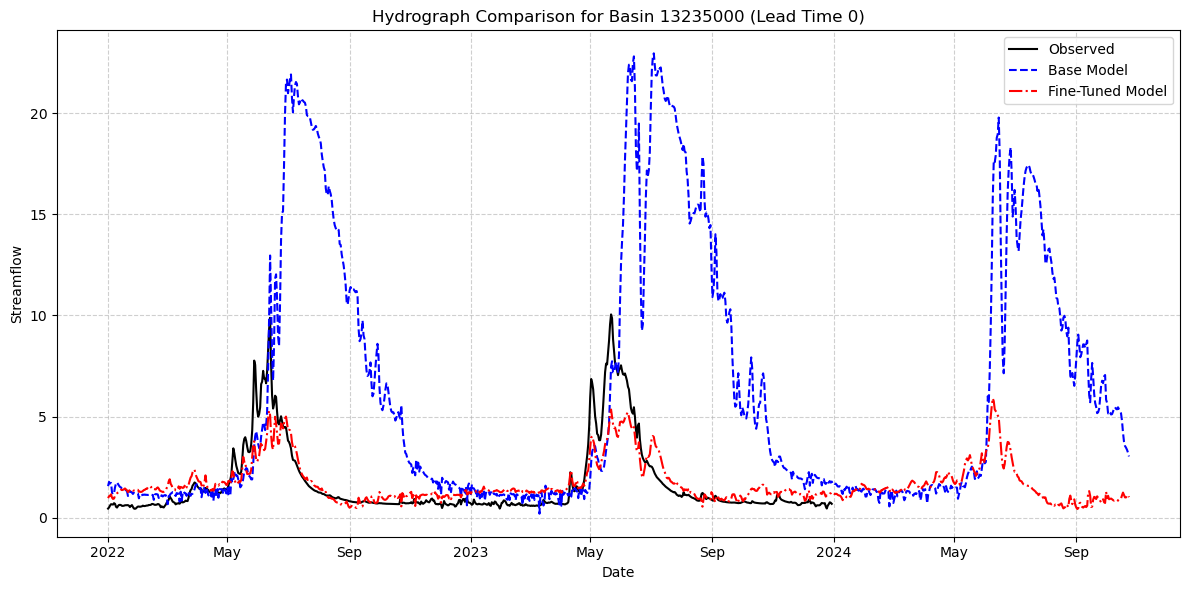

In [17]:
# --- Fine-Tuning: Visualize Hydrographs ---

# This cell generates a hydrograph plot to visually compare the observed streamflow
# against the simulated streamflow from both the base model and the fine-tuned model.
# This visualization is critical for understanding the models' ability to reproduce
# the hydrological behavior of the selected basin, especially at lead time zero (the current day's prediction).

# Define the lead time for the hydrograph comparison. LEAD_TIME_ZERO typically refers
# to the hindcast or current-day prediction, which is often the most accurate.
LEAD_TIME_ZERO = 0

# Normalize the fine-tuning basin ID for consistent data selection.
# The `basin_widget.value` holds the currently selected basin from the interactive dropdown
# in the previous cell (Ii3MpfSvCZ9U), ensuring the hydrograph is plotted for the user's chosen basin.
finetune_basin = basin_widget.value

# Select observed streamflow data for the chosen fine-tuning basin at the specified lead time.
# `finetune_data` contains the loaded observed data (streamflow_obs) for the fine-tuned run.
obs_hydrograph = finetune_data['streamflow_obs'].sel(
    basin=finetune_basin,
    time_step=LEAD_TIME_ZERO
)

# Select base model simulated streamflow data for the chosen fine-tuning basin at lead time 0.
# `base_model_data` contains the loaded simulation results (streamflow_sim) for the base model.
base_model_hydrograph = base_model_data['streamflow_sim'].sel(
    basin=finetune_basin,
    time_step=LEAD_TIME_ZERO
)

# Select fine-tuned model simulated streamflow data for the chosen fine-tuning basin at lead time 0.
# `finetune_data` also contains the simulation results for the fine-tuned model.
finetune_model_hydrograph = finetune_data['streamflow_sim'].sel(
    basin=finetune_basin,
    time_step=LEAD_TIME_ZERO
)

# Create the plot figure.
plt.figure(figsize=(12, 6))

# Plot the hydrographs using different colors and line styles for easy differentiation.
# Observed streamflow is shown in black, base model in blue (dashed), and fine-tuned model in red (dash-dot).
obs_hydrograph.plot(label='Observed', color='black')
base_model_hydrograph.plot(label='Base Model', color='blue', linestyle='--')
finetune_model_hydrograph.plot(label='Fine-Tuned Model', color='red', linestyle='-.')

# Add title, axis labels, and a grid for clarity.
plt.title(f"Hydrograph Comparison for Basin {FINE_TUNING_BASIN} (Lead Time {LEAD_TIME_ZERO})")
plt.xlabel("Date")
plt.ylabel("Streamflow")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend() # Display the legend to identify each line
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the generated plot

## Look at Basin Area Distribution

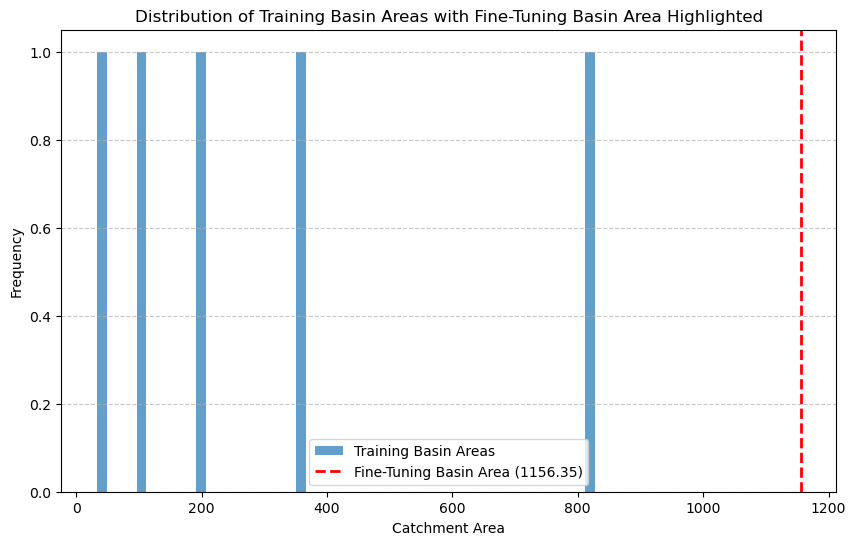

In [18]:
# Load attributes data from the specified CSV file.
# This DataFrame contains various hydrological attributes for different basins, including their area.
attributes_df = pd.read_csv(ATTRIBUTES_FILE_PATH)

# Normalize the 'gauge_id' column to match the format used throughout the notebook (e.g., 'camels_XXXXXX').
# This is crucial for consistent comparison and selection of basin data.
attributes_df['gauge_id_normalized'] = attributes_df['gauge_id'].apply(backend.normalize_id)

# Get the fine-tuning basin ID from the `basin_widget` (from the previous interactive cell).
# This ensures that the highlighted basin in the plot is the one currently selected by the user.
finetune_basin_id = basin_widget.value

# Normalize train basin IDs for consistent comparison with the normalized `gauge_id` in `attributes_df`.
# This set is used to filter for basins that were part of the original training set.
train_basin_ids_normalized = set(backend.normalize_id(bid) for bid in train_basin_ids)

# Filter the `attributes_df` to include only the basins that were used for training.
# We select both the original 'gauge_id' and the 'area' for these basins.
training_basin_areas = attributes_df[
    attributes_df['gauge_id_normalized'].isin(train_basin_ids_normalized)
][['gauge_id', 'area']]

# Get the area of the fine-tuning basin from `attributes_df`.
# We check if `attributes_df` and its required columns exist to prevent errors.
# If the fine-tuning basin's area is found, it's stored; otherwise, a warning is printed.
if 'attributes_df' in globals() and 'gauge_id_normalized' in attributes_df.columns and 'area' in attributes_df.columns:
    finetune_basin_area_row = attributes_df[attributes_df['gauge_id_normalized'] == backend.normalize_id(finetune_basin_id)]
    if not finetune_basin_area_row.empty:
        finetune_basin_area = finetune_basin_area_row['area'].iloc[0]
    else:
        finetune_basin_area = None
        print(f"Warning: Area not found for fine-tuning basin ID: {finetune_basin_id}")
else:
    finetune_basin_area = None
    print("Warning: attributes_df not available or missing required columns.")


# Plot a histogram of the training basin areas.
# This visualizes the distribution of catchment areas for the basins the base model was trained on.
plt.figure(figsize=(10, 6))
plt.hist(training_basin_areas['area'], bins=50, alpha=0.7, label='Training Basin Areas')

# Add a vertical line or marker for the fine-tuning basin area if it was found.
# This helps to visually compare the size of the fine-tuning basin relative to the training basins.
if finetune_basin_area is not None:
    plt.axvline(finetune_basin_area, color='red', linestyle='dashed', linewidth=2, label=f'Fine-Tuning Basin Area ({finetune_basin_area:.2f})')

# Set plot labels and title for clarity.
plt.xlabel("Catchment Area")
plt.ylabel("Frequency")
plt.title("Distribution of Training Basin Areas with Fine-Tuning Basin Area Highlighted")
plt.legend() # Display the legend to differentiate between training areas and the fine-tuning basin
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for readability
plt.show() # Display the generated plot

### Why is Basin Area Distribution Important for Fine-Tuning?

The basin area distribution plot (from the cell above) is crucial for understanding our fine-tuning strategy, especially concerning the `static_attributes_fc` layer. Here's why:

When we fine-tune a pre-trained model, our goal is often to improve its performance on a specific, potentially 'out-of-distribution' target. The base model was trained on a set of basins, and its performance might be suboptimal for basins with characteristics significantly different from those it was trained on.

1.  **Basin Area as a Key Characteristic:** Basin area is a fundamental static attribute of a catchment. If the fine-tuning basin's area falls significantly outside the range or distribution of the training basin areas (as visualized in the histogram), it suggests that the base model might not have learned a robust representation for basins of that particular size.

2.  **Role of `static_attributes_fc` Layer:** The `static_attributes_fc` (static attributes fully connected) layer in the model is specifically designed to process these static basin characteristics (like area, elevation, geology, etc.). It learns to embed these attributes into a representation that the rest of the hydrological model can use.

3.  **Why Fine-Tune This Layer:** If our target fine-tuning basin has static attributes (like area) that are dissimilar to the bulk of the training data, the `static_attributes_fc` layer might be producing a suboptimal embedding for it. By fine-tuning *only* this layer, we allow the model to learn an improved, more accurate representation for the unique static characteristics of our target basin, without retraining the entire, more complex hydrological prediction part of the model. This targeted approach is more efficient and prevents 'catastrophic forgetting'—where retraining the whole model might degrade performance on the attributes it already learned well for the original training distribution.

In essence, if the target basin is an outlier in terms of area, fine-tuning `static_attributes_fc` directly addresses this discrepancy by teaching the model how to better interpret and utilize that specific characteristic for the target basin's predictions.